<a href="https://colab.research.google.com/github/GALI-SAI-SHANKAR/Threat-Alert-AI/blob/main/Source%20Code/Speech%20Emotion%20Dection/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model

In [ ]:
!pip install --upgrade tensorflow

In [2]:
from google.colab import files
data = files.upload()

Saving features_rmse_mfcc.csv to features_rmse_mfcc.csv


In [3]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import io


extracted_df = pd.read_csv(io.StringIO(data['features_rmse_mfcc.csv'].decode('utf-8')))

In [ ]:
X = extracted_df.drop(["labels"], axis = 1)
print(extracted_df.head(10))

In [5]:
from tensorflow.keras.utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(extracted_df.labels)
extracted_df['categorical_label'] = le.transform(extracted_df.labels)
Y = extracted_df.categorical_label

Y = to_categorical(Y)

print(extracted_df['labels'].unique())

X = np.array(X)
Y = np.array(Y)
X = np.squeeze(X)
X = np.expand_dims(X,-1)
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=42)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


#Vanilla RNN

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Dropout
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as pyplot

In [7]:
RNN_model = Sequential([
    SimpleRNN(256,input_shape = (40,1)),
    Dense(128,activation = 'relu', kernel_regularizer= keras.regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(32,activation = 'relu', kernel_regularizer= keras.regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(6,activation='softmax', kernel_regularizer= keras.regularizers.l2(0.001))
])

In [8]:
RNN_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 103,270
Trainable params: 103,270
Non-trai

In [9]:
RNN_history = RNN_model.fit(x_train,y_train,validation_data = (x_val,y_val),epochs = 50)

Epoch 1/50
155/155 [==============================] - 7s 33ms/step - loss: 1.9726 - accuracy: 0.2252 - val_loss: 2.0625 - val_accuracy: 0.1724
Epoch 2/50
155/155 [==============================] - 5s 31ms/step - loss: 1.8738 - accuracy: 0.2638 - val_loss: 1.8948 - val_accuracy: 0.2452
Epoch 3/50
155/155 [==============================] - 5s 32ms/step - loss: 1.8272 - accuracy: 0.2751 - val_loss: 1.8194 - val_accuracy: 0.2720
Epoch 4/50
155/155 [==============================] - 5s 31ms/step - loss: 1.7818 - accuracy: 0.2793 - val_loss: 1.7763 - val_accuracy: 0.2682
Epoch 5/50
155/155 [==============================] - 5s 31ms/step - loss: 1.7631 - accuracy: 0.2842 - val_loss: 1.7698 - val_accuracy: 0.2759
Epoch 6/50
155/155 [==============================] - 5s 31ms/step - loss: 1.7248 - accuracy: 0.2896 - val_loss: 1.7452 - val_accuracy: 0.2605
Epoch 7/50
155/155 [==============================] - 5s 31ms/step - loss: 1.7136 - accuracy: 0.2882 - val_loss: 1.7693 - val_accuracy: 0.2644

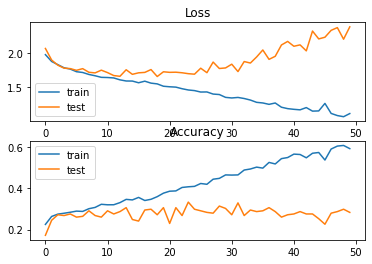

In [10]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(RNN_history.history['loss'], label='train')
pyplot.plot(RNN_history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(RNN_history.history['accuracy'], label='train')
pyplot.plot(RNN_history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()


In [11]:
# predict probabilities for test set
RNN_yhat_probs = RNN_model.predict(x_test, verbose=0)
# predict crisp classes for test set
RNN_yhat_classes = np.argmax(RNN_yhat_probs,1)
y_true_classes = np.argmax(y_test,1)

In [12]:
f1 = f1_score(y_true_classes,RNN_yhat_classes,pos_label='positive',average='micro')
print('F1 score: %f' % f1)

F1 score: 0.304387


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


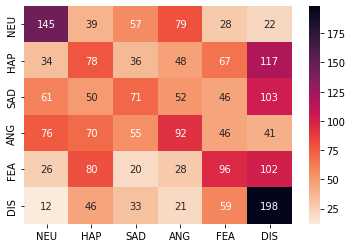

In [13]:
import seaborn as sns
crema_emotions = {
    'NEU':'neutral',
    'HAP':'happy',
    'SAD':'sad',
    'ANG':'angry',
    'FEA':'fear',
    'DIS':'disgust'}
    
matrix = confusion_matrix(y_true_classes, RNN_yhat_classes)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = crema_emotions, yticklabels = crema_emotions)

#LSTM

In [14]:
import tensorflow.keras as keras
LSTM_model = Sequential([
    LSTM(256,input_shape = (40,1)),
    Dense(128,activation = 'relu', kernel_regularizer= keras.regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(64,activation = 'relu', kernel_regularizer= keras.regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(32,activation = 'relu', kernel_regularizer= keras.regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(6,activation='softmax', kernel_regularizer= keras.regularizers.l2(0.001))
])

In [15]:
LSTM_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)               

In [ ]:
LSTM_history = LSTM_model.fit(x_train,y_train,validation_data = (x_val,y_val),
                         batch_size = 64,
                         epochs = 50,
                         shuffle = True)

Epoch 1/50
78/78 [==============================] - 19s 209ms/step - loss: 1.9628 - accuracy: 0.2359 - val_loss: 1.7859 - val_accuracy: 0.3180
Epoch 2/50
78/78 [==============================] - 14s 176ms/step - loss: 1.7883 - accuracy: 0.2838 - val_loss: 1.7222 - val_accuracy: 0.3487
Epoch 3/50
78/78 [==============================] - 14s 175ms/step - loss: 1.6978 - accuracy: 0.3213 - val_loss: 1.6646 - val_accuracy: 0.3487
Epoch 4/50
78/78 [==============================] - 15s 190ms/step - loss: 1.6454 - accuracy: 0.3381 - val_loss: 1.5641 - val_accuracy: 0.3908
Epoch 5/50
78/78 [==============================] - 14s 174ms/step - loss: 1.6107 - accuracy: 0.3407 - val_loss: 1.5556 - val_accuracy: 0.3755
Epoch 6/50
78/78 [==============================] - 18s 225ms/step - loss: 1.5866 - accuracy: 0.3486 - val_loss: 1.6396 - val_accuracy: 0.2950
Epoch 7/50
78/78 [==============================] - 16s 202ms/step - loss: 1.5578 - accuracy: 0.3698 - val_loss: 1.5343 - val_accuracy: 0.3678

In [ ]:
import pickle
pickle.dump(LSTM_model,open('model.pkl','wb'))

INFO:tensorflow:Assets written to: ram://67d0aff6-fe66-4021-aba5-e3b45079ff50/assets


INFO:tensorflow:Assets written to: ram://67d0aff6-fe66-4021-aba5-e3b45079ff50/assets


In [ ]:
LSTM_model.evaluate(x_test, y_test)

70/70 [==============================] - 3s 42ms/step - loss: 1.5489 - accuracy: 0.4190


[1.5489201545715332, 0.4189794063568115]

In [ ]:
emotions = {
    '0':'angry',
    '1':'disgust',
    '2':'fear',
    '3':'happy',
    '4':'neutral',
    '5':'sad'
}

In [ ]:
print(emotions.get('1'))

disgust


In [ ]:
y_train[1]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
y_pred = LSTM_model.predict(x_test)
y_pred[0]

array([4.0537232e-01, 5.0037742e-01, 4.3196278e-03, 8.3301522e-02,
       6.5580769e-03, 7.1028691e-05], dtype=float32)

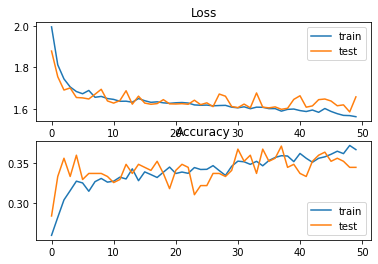

In [ ]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(LSTM_history.history['loss'], label='train')
pyplot.plot(LSTM_history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(LSTM_history.history['accuracy'], label='train')
pyplot.plot(LSTM_history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yhat_probs = LSTM_model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,1)
y_true_classes = np.argmax(y_test,1)

In [ ]:
yhat_classes.shape

(2234,)

In [ ]:
y_true_classes.shape
result = []
for i in range(len(y_true_classes)):
  e = str(y_true_classes[i])
  result.append(emotions.get(e))

res = np.array(result)
res.shape
resdf = pd.DataFrame(res)
l = pd.DataFrame(extracted_df['labels']).to_numpy()
l = pd.DataFrame(l)
l['row_num'] = np.arange(len(l))
resdf['row_num'] = np.arange(len(resdf))
result = pd.merge(l, resdf, on="row_num")
print(result)
#result.to_csv('predict.csv')

          0_x  row_num      0_y
0       angry        0    angry
1     disgust        1     fear
2        fear        2  disgust
3       happy        3      sad
4     neutral        4  disgust
...       ...      ...      ...
2229    angry     2229  neutral
2230  disgust     2230     fear
2231     fear     2231      sad
2232    happy     2232    angry
2233  neutral     2233  disgust

[2234 rows x 3 columns]


In [ ]:
f1 = f1_score(y_true_classes,yhat_classes,pos_label='positive'
                                           ,average='micro')
print('F1 score: %f' % f1)

F1 score: 0.402865


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


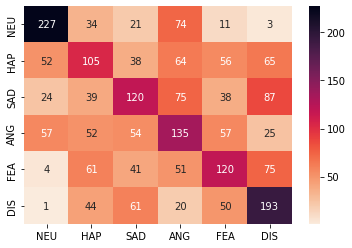

In [ ]:
import seaborn as sns

crema_emotions = {
    'NEU':'neutral',
    'HAP':'happy',
    'SAD':'sad',
    'ANG':'angry',
    'FEA':'fear',
    'DIS':'disgust'}
    

matrix = confusion_matrix(y_true_classes,yhat_classes)
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = crema_emotions, yticklabels = crema_emotions)

In [ ]:
!ls

drive  features_rmse_mfcc.csv  GIRL_bachao_fear.wav  predict.csv  sample_data


In [ ]:
!pip install SoundFile

In [ ]:
import pickle

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

FIG_SIZE = (5, 3)

file = "./GIRL_help_fear.wav"

signal, sample_rate = librosa.load(file, sr=22050)

hop_length = 512  # in num. of samples
n_fft = 2048  # window in num. of samples

MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

p = model.predict(MFCCs)

print(p)
